In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
from PIL import Image
from typing import *

from pulp_frontnet.PyTorch.Frontnet.DataProcessor import DataProcessor
from pulp_frontnet.PyTorch.Frontnet.Dataset import Dataset
from pulp_frontnet.PyTorch.Frontnet.Frontnet import FrontnetModel
from pulp_frontnet.PyTorch.Frontnet import Utils
from pulp_frontnet.PyTorch.Frontnet.Utils import ModelManager
from pulp_frontnet.PyTorch.Frontnet.ModelTrainer import ModelTrainer

from patch_optimizers.utils import *
from patch_optimizers.sliding_window_optimizer import SlidingWindowOptimizer
from patch_optimizers.simulated_annealing_optimizer import SimulatedAnnealingOptimizer
from patch_optimizers.random_optimizer import RandomOptimizer
from patch_optimizers.genetic_optimizer import GeneticOptimizer

In [2]:
!python -V

Python 3.11.5


In [3]:
!system_profiler SPSoftwareDataType SPHardwareDataType

Software:

    System Software Overview:

      System Version: macOS 13.5.1 (22G90)
      Kernel Version: Darwin 22.6.0
      Boot Volume: Macintosh HD
      Boot Mode: Normal
      Computer Name: MacBook Pro (Febrin)
      User Name: Febrin (febrin)
      Secure Virtual Memory: Enabled
      System Integrity Protection: Enabled
      Time since boot: 55 days, 1 hour, 58 minutes

Hardware:

    Hardware Overview:

      Model Name: MacBook Pro
      Model Identifier: MacBookPro18,3
      Model Number: Z15H0001DZE/A
      Chip: Apple M1 Pro
      Total Number of Cores: 10 (8 performance and 2 efficiency)
      Memory: 32 GB
      System Firmware Version: 8422.141.2
      OS Loader Version: 8422.141.2
      Serial Number (system): YMC49HFQTK
      Hardware UUID: 04F01333-2A5A-5D6E-AF9A-7CA89AB0AF73
      Provisioning UDID: 00006000-001470A40A06801E
      Activation Lock Status: Enabled



## Load model

In [4]:
model_path = "pulp_frontnet/PyTorch/Models/Frontnet160x32.pt"
model = FrontnetModel()
ModelManager.Read(model_path, model)
model.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 80]             800
       BatchNorm2d-2           [-1, 32, 48, 80]              64
              ReLU-3           [-1, 32, 48, 80]               0
         MaxPool2d-4           [-1, 32, 24, 40]               0
            Conv2d-5           [-1, 32, 12, 20]           9,216
       BatchNorm2d-6           [-1, 32, 12, 20]              64
              ReLU-7           [-1, 32, 12, 20]               0
            Conv2d-8           [-1, 32, 12, 20]           9,216
       BatchNorm2d-9           [-1, 32, 12, 20]              64
             ReLU-10           [-1, 32, 12, 20]               0
        ConvBlock-11           [-1, 32, 12, 20]               0
           Conv2d-12            [-1, 64, 6, 10]          18,432
      BatchNorm2d-13            [-1, 64, 6, 10]             128
             ReLU-14            [-1, 64

Frontnet(
  (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ConvBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (layer2): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

## Load dataset

In [5]:
testset_path = "pulp_frontnet/PyTorch/Data/Data/160x96StrangersTestset.pickle"
[x_test, y_test] = DataProcessor.ProcessTestData(testset_path)

trainset_path = "pulp_frontnet/PyTorch/Data/Data/160x96OthersTrainsetAug.pickle"
[x_train, y_train] = DataProcessor.ProcessTestData(trainset_path)


# Create the PyTorch data loaders
test_set = Dataset(x_test, y_test)
test_loader = data.DataLoader(dataset=test_set, batch_size=32, shuffle=False, num_workers=8)
test_loader_single = data.DataLoader(dataset=test_set, batch_size=1, shuffle=False, num_workers=1)

train_set = Dataset(x_train, y_train)
train_loader = data.DataLoader(dataset=train_set, batch_size=32, shuffle=False, num_workers=8)
train_loader_single = data.DataLoader(dataset=train_set, batch_size=1, shuffle=False, num_workers=1)

## Cost function 

Model output is `(x, y, z, theta)`, where

* x - up down (depth, distance), between 0 and 3 m
* y - left right
* z - height
* theta - angle (not very reliable), 0 when person is facing the drone, 180 (in radians) when the person looks in the opposite direction


## RandomOptimizer

In [6]:
def run_random_optimizer_and_print_results(
    img,
    random_optimizer,
):
    best_cost, optimal_greedy_points = random_optimizer.run(
        img=img[0],
    )

    print("\n\n ======= \n\n")
    print(f"Results after generating {random_optimizer._n_dots_to_generate} dots.")
    print("Best cost for a single point", best_cost)
    print(f"Cost on raw image: {random_optimizer._cost_f(model(img), next(iter(test_loader_single))[1])}")
    print(f"Prediction on raw: {model(img)[0]}")
    print(optimal_greedy_points)

    for x, y in optimal_greedy_points:
        apply_path(
            img=img[0][0].numpy(),
            x=x,
            y=y,
            size=10,
        )

    print(
        "Total cost for all points: ", 
        random_optimizer._cost_f(model(img), next(iter(test_loader_single))[1])
    )
    print(f"Prediction after patches: {model(img)[0]}")
    plt.imshow(img[0][0].numpy(), cmap="gray")
    plt.title(f"Generated {random_optimizer._n_dots_to_generate} random dots")
    plt.show()





Results after generating 10 dots.
Best cost for a single point 0.24683423
Cost on raw image: [0.23846865 0.3368376  3.1264522  1.5197303 ]
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(35, 58), (52, 75), (2, 63)]
Total cost for all points:  [0.9705336 0.0069811 1.6163397 0.5416213]
Prediction after patches: tensor([[1.7292]], grad_fn=<UnsqueezeBackward0>)


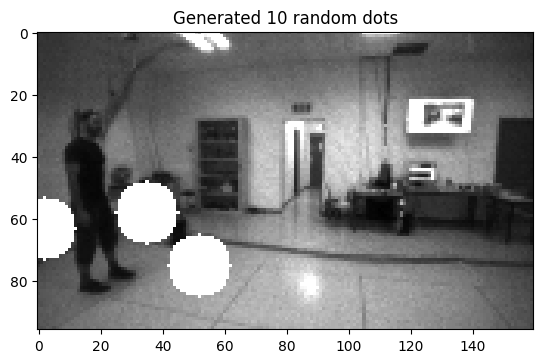

CPU times: user 251 ms, sys: 875 ms, total: 1.13 s
Wall time: 2.83 s


In [7]:
%%time

img = next(iter(test_loader_single))[0]
random_optimizer = RandomOptimizer(
    cost_f=lambda prediction_with_patch, model_raw_prediction: single_vector_element_cost_f(
        prediction_with_patch=prediction_with_patch, 
        model_raw_prediction=model_raw_prediction, 
        element_index=0
    ),
    model=model,
    n_dots_to_generate=10,
    k_dots=3,
    dot_size=10,
)
run_random_optimizer_and_print_results(
    img=img,
    random_optimizer=random_optimizer,
)





Results after generating 100 dots.
Best cost for a single point 0.87156254
Cost on raw image: [0.23846865 0.3368376  3.1264522  1.5197303 ]
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(21, 64), (17, 76), (66, 46)]
Total cost for all points:  [2.0218215  0.12474886 0.6965613  0.08951961]
Prediction after patches: tensor([[1.2925]], grad_fn=<UnsqueezeBackward0>)


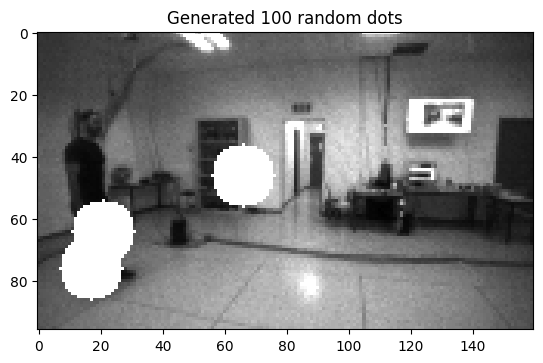

CPU times: user 412 ms, sys: 709 ms, total: 1.12 s
Wall time: 2.62 s


In [8]:
%%time

img = next(iter(test_loader_single))[0]
random_optimizer = RandomOptimizer(
    cost_f=lambda prediction_with_patch, model_raw_prediction: single_vector_element_cost_f(
        prediction_with_patch=prediction_with_patch, 
        model_raw_prediction=model_raw_prediction, 
        element_index=0
    ),
    model=model,
    n_dots_to_generate=100,
    k_dots=3,
    dot_size=10,
)
run_random_optimizer_and_print_results(
    img=img,
    random_optimizer=random_optimizer,
)





Results after generating 1000 dots.
Best cost for a single point 0.47344452
Cost on raw image: [0.23846865 0.3368376  3.1264522  1.5197303 ]
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(12, 60), (11, 59), (14, 60)]
Total cost for all points:  [1.38393    0.01159841 1.166626   0.2966985 ]
Prediction after patches: tensor([[1.5380]], grad_fn=<UnsqueezeBackward0>)


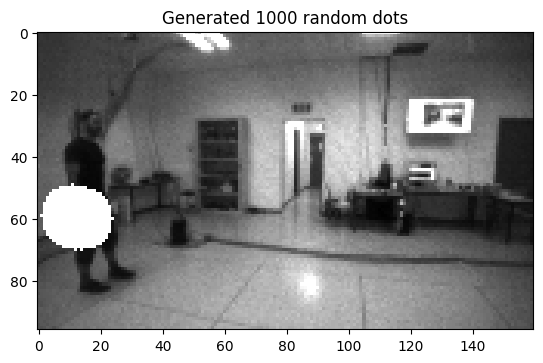

CPU times: user 1.77 s, sys: 3.88 s, total: 5.65 s
Wall time: 5.24 s


In [9]:
%%time

img = next(iter(test_loader_single))[0]
random_optimizer = RandomOptimizer(
    cost_f=lambda prediction_with_patch, model_raw_prediction: single_vector_element_cost_f(
        prediction_with_patch=prediction_with_patch, 
        model_raw_prediction=model_raw_prediction, 
        element_index=0
    ),
    model=model,
    n_dots_to_generate=1000,
    k_dots=3,
    dot_size=10,
)
run_random_optimizer_and_print_results(
    img=img,
    random_optimizer=random_optimizer,
)

## SlidingWindowOptimizer
Greedy selection

In [10]:
def run_sliding_window_optimizer_and_print_results(
    img,
    sliding_window_optimizer,
):
    best_cost, optimal_greedy_points = sliding_window_optimizer.run(
        img=img[0],
    )

    print("\n\n ======= \n\n")
    print(f"Results for stride = {sliding_window_optimizer._stride}")
    print("Best cost for a single point", best_cost)
    print(f"Cost on raw image: {sliding_window_optimizer._cost_f(model(img), next(iter(test_loader_single))[1])}")
    print(f"Prediction on raw: {model(img)[0]}")
    print(optimal_greedy_points)

    for x, y in optimal_greedy_points:
        apply_path(
            img=img[0][0].numpy(),
            x=x,
            y=y,
            size=10,
        )

    print(
        "Total cost for all points: ", 
        sliding_window_optimizer._cost_f(model(img), next(iter(test_loader_single))[1])
    )
    print(f"Prediction after patches: {model(img)[0]}")
    plt.imshow(img[0][0].numpy(), cmap="gray")
    plt.title(f"Stride = {sliding_window_optimizer._stride}")
    plt.show()





Results for stride = 5
Best cost for a single point 0.63457227
Cost on raw image: [0.23846865 0.3368376  3.1264522  1.5197303 ]
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(15, 55), (15, 60), (25, 55)]
Total cost for all points:  [1.3048995  0.00541878 1.2414154  0.33499092]
Prediction after patches: tensor([[1.5721]], grad_fn=<UnsqueezeBackward0>)


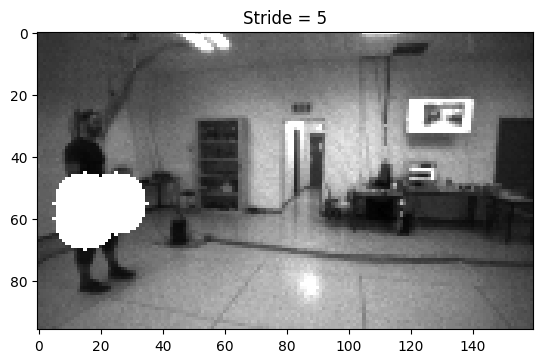





Results for stride = 10
Best cost for a single point 0.40607807
Cost on raw image: [0.23846865 0.3368376  3.1264522  1.5197303 ]
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(20, 80), (30, 80), (10, 60)]
Total cost for all points:  [0.9966302  0.00495559 1.5830584  0.5224287 ]
Prediction after patches: tensor([[1.7161]], grad_fn=<UnsqueezeBackward0>)


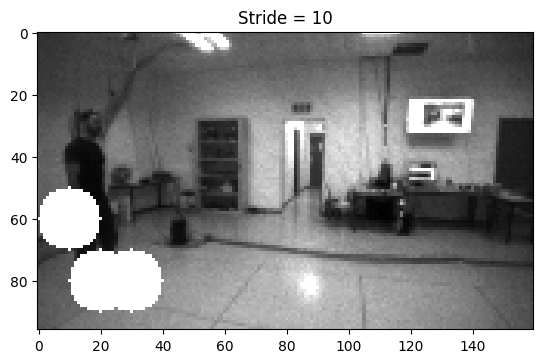





Results for stride = 15
Best cost for a single point 0.54258174
Cost on raw image: [0.23846865 0.3368376  3.1264522  1.5197303 ]
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(15, 60), (30, 75), (45, 75)]
Total cost for all points:  [2.4975195  0.2617802  0.45718685 0.01981105]
Prediction after patches: tensor([[1.1340]], grad_fn=<UnsqueezeBackward0>)


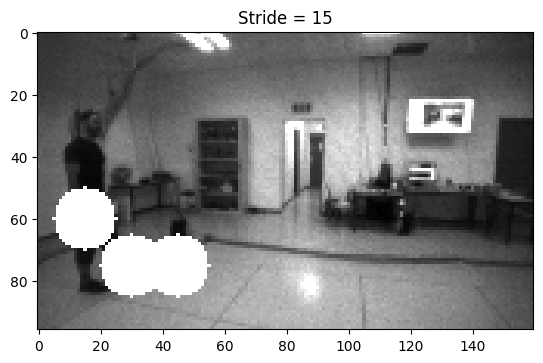

CPU times: user 4.64 s, sys: 9.66 s, total: 14.3 s
Wall time: 13.9 s


In [11]:
%%time

for stride in (5, 10, 15):
    img = next(iter(test_loader_single))[0]
    sliding_window_optimizer = SlidingWindowOptimizer(
        cost_f=lambda prediction_with_patch, model_raw_prediction: single_vector_element_cost_f(
            prediction_with_patch=prediction_with_patch, 
            model_raw_prediction=model_raw_prediction, 
            element_index=0
        ),
        model=model,
        k_dots=3,
        dot_size=10,
        stride=stride,
    )
    run_sliding_window_optimizer_and_print_results(
        img=img,
        sliding_window_optimizer=sliding_window_optimizer,
    )

## Simulated annealing

### Custom implementation

as `scipy.optimize.basinhopping` did not work

In [12]:
simulated_anneling_optimizer = SimulatedAnnealingOptimizer(
    x0=(110, 20),
    stride=10,
    max_iters=100,
    model=model,
    cost_f=lambda prediction_with_patch, model_raw_prediction: single_vector_element_cost_f(
        prediction_with_patch=prediction_with_patch, 
        model_raw_prediction=model_raw_prediction, 
        element_index=0
    ),
    debug=True
)

Simulated Annealing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 402.80it/s]


Steps: 100
Best solution: (13, 61)
Best cost: -0.5238912105560303
Number of good jumps: 48
Number of random jumps: 50
Cost: 0.5238912105560303
Prediction on raw: [tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>), tensor([[1.5141]], grad_fn=<UnsqueezeBackward0>), tensor([[0.4459]], grad_fn=<UnsqueezeBackward0>), tensor([[0.5643]], grad_fn=<UnsqueezeBackward0>)]
Prediction with patch: [2.2261, 1.5141, 0.4459, 0.5643]


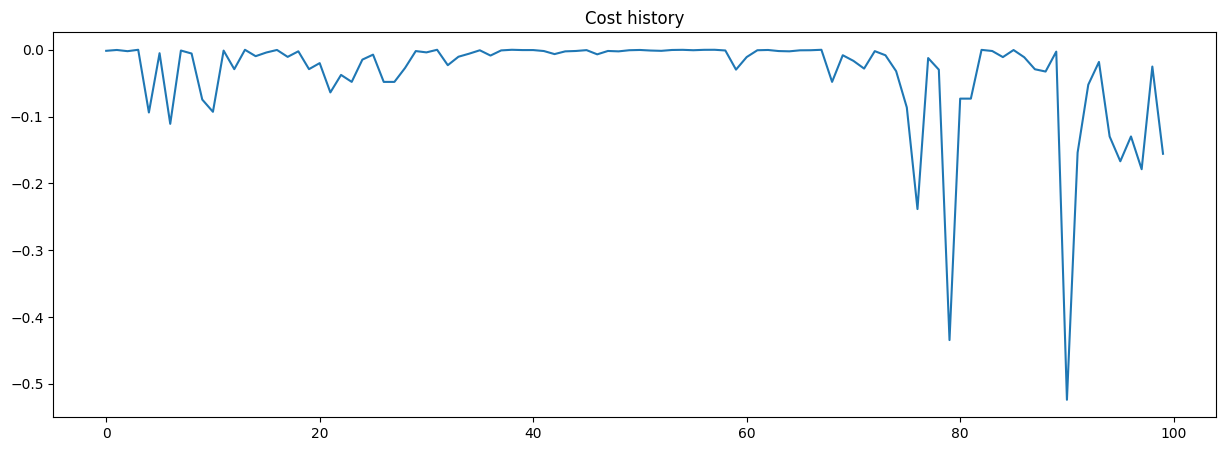

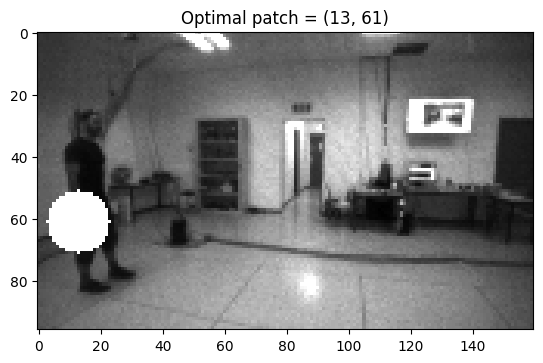

ans:  (0.5238912, (13, 61))
[(97, 6), (96, 4), (112, 16), (109, 18), (97, 31), (92, 31), (100, 50), (104, 63), (95, 67), (103, 52), (99, 53), (101, 66), (96, 69), (86, 72), (102, 83), (105, 84), (89, 76), (96, 95), (107, 77), (110, 61), (98, 59), (108, 53), (96, 58), (106, 56), (120, 52), (108, 64), (116, 61), (116, 61), (119, 43), (103, 27), (108, 13), (107, 0), (115, 0), (95, 8), (113, 0), (130, 0), (114, 0), (128, 0), (147, 15), (146, 15), (154, 3), (160, 8), (153, 8), (160, 12), (144, 0), (138, 0), (141, 0), (150, 0), (160, 12), (160, 3), (144, 6), (152, 16), (142, 26), (154, 45), (160, 50), (160, 59), (160, 50), (157, 43), (145, 37), (125, 56), (144, 57), (153, 61), (160, 58), (143, 46), (124, 26), (129, 45), (110, 57), (116, 44), (106, 56), (103, 68), (115, 55), (99, 44), (83, 54), (98, 70), (82, 59), (62, 63), (45, 74), (49, 58), (30, 66), (24, 56), (18, 58), (18, 58), (0, 55), (13, 44), (28, 39), (10, 30), (12, 19), (0, 14), (15, 26), (0, 43), (13, 61), (27, 61), (43, 65), (42,

In [13]:
ans = simulated_anneling_optimizer.run(img=next(iter(test_loader_single))[0][0])
print("ans: ", ans)
print(simulated_anneling_optimizer.solution_history)

### Jumping visualization

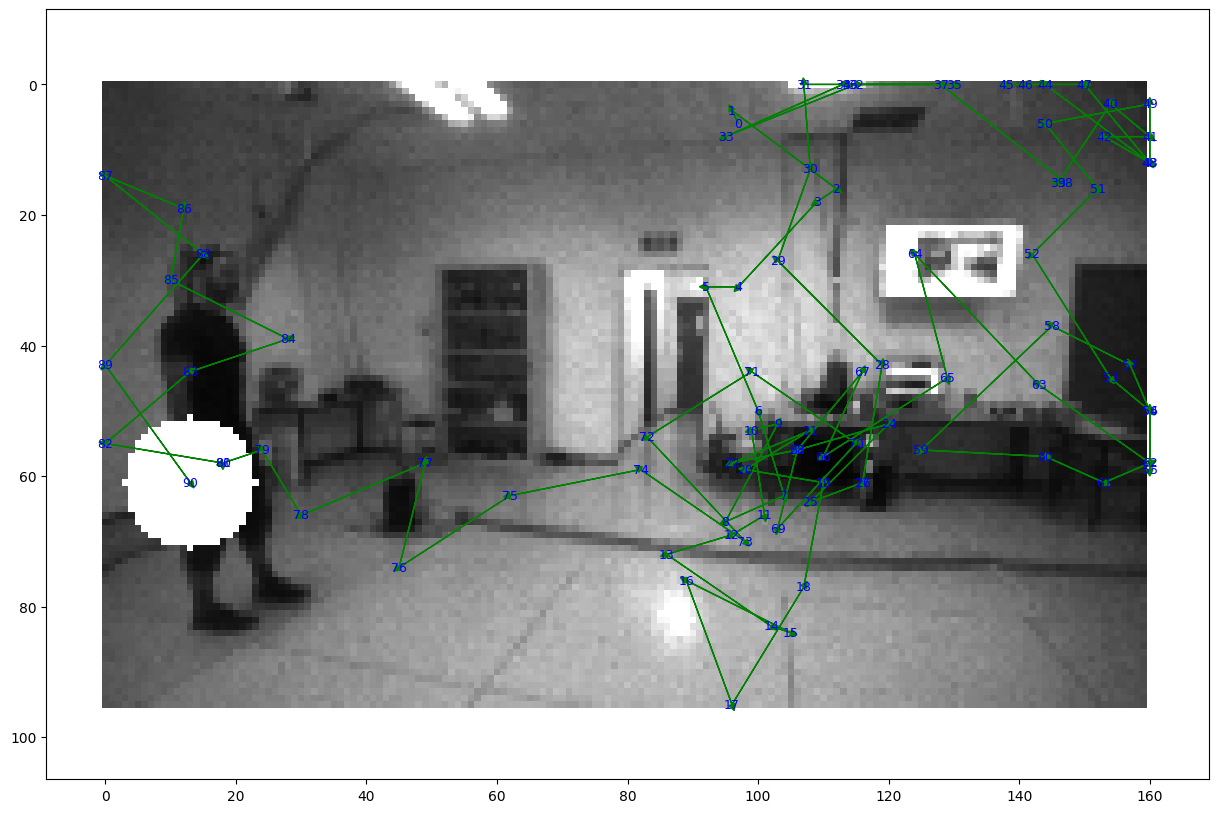

In [14]:
plt.figure(figsize=(15, 10))

img = next(iter(test_loader_single))[0].numpy()[0][0]
apply_path(
    img=img,
    x=ans[1][0],
    y=ans[1][1],
    size=10,
)
plt.imshow(img, cmap='gray')

for i, (x, y) in enumerate(simulated_anneling_optimizer.solution_history):
    # plt.scatter(x, y, c='blue')
    plt.text(x, y, str(i), fontsize=9, ha='center', va='center', color='blue', alpha=1.0)
    if (x, y) == ans[1]:
        break

# Plotting the arrows
for i in range(len(simulated_anneling_optimizer.solution_history) - 1):
    x_start, y_start = simulated_anneling_optimizer.solution_history[i]
    x_end, y_end = simulated_anneling_optimizer.solution_history[i + 1]
    plt.arrow(x_start, y_start, x_end - x_start, y_end - y_start, head_width=1, head_length=1, fc='green', ec='green')
    if (x_end, y_end ) == ans[1]:
        break

plt.axis('equal')
plt.show()

## GeneticOptimizer

 

In [39]:
genetic_optimizer = GeneticOptimizer(
    n_iters=50,
    population_size=10,
    model=model,
    cost_f=lambda prediction_with_patch, model_raw_prediction: single_vector_element_cost_f(
        prediction_with_patch=prediction_with_patch, 
        model_raw_prediction=model_raw_prediction, 
        element_index=0
    ),
    max_x=160,
    max_y=96,
    dot_size=10,
    elitism=False,
    debug=True,
)

In [40]:
ans = genetic_optimizer.run(
    img=next(iter(test_loader_single))[0][0],
)
print(ans)

Running genetic optimizer ...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 72.19it/s]

(0.383352667093277, array([19.00414673, 52.1849426 ]))


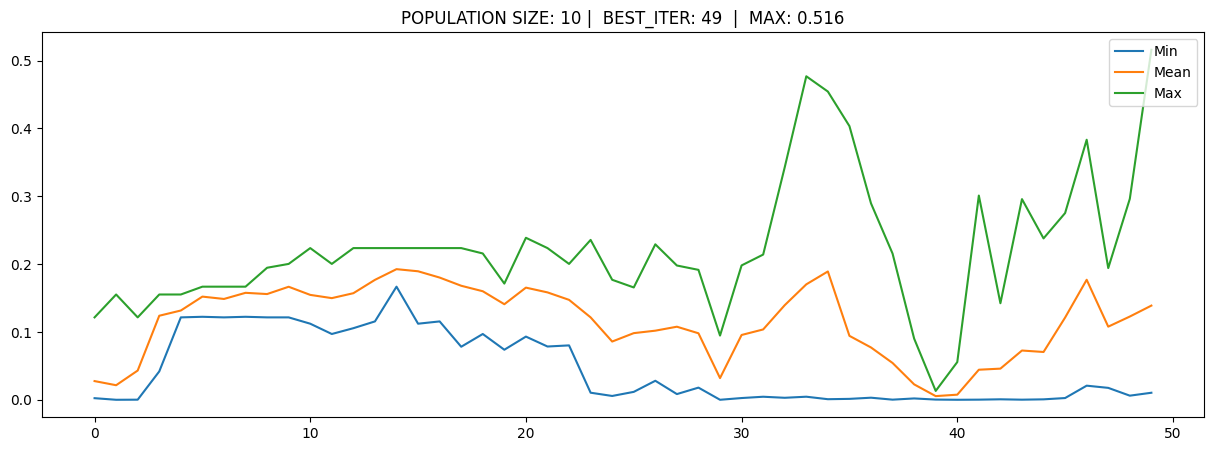

In [41]:
genetic_optimizer.plot_cost()

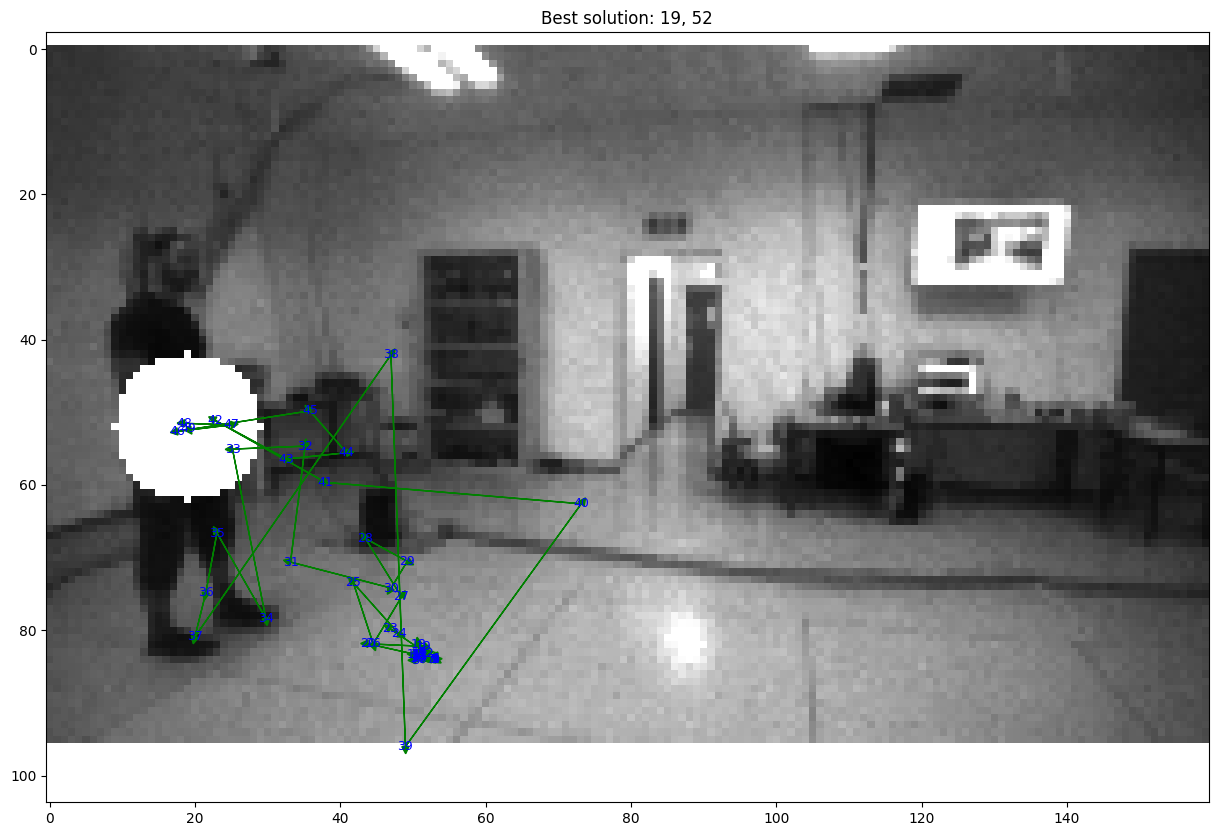

In [42]:
plt.figure(figsize=(15, 10))

img = next(iter(test_loader_single))[0].numpy()[0][0]


apply_path(
    img=img,
    x=int(ans[1][0]),
    y=int(ans[1][1]),
    size=10,
)
plt.imshow(img, cmap='gray')

for i, (x, y) in enumerate(genetic_optimizer.best_solution_history):
    # plt.scatter(x, y, c='blue')
    plt.text(x, y, str(i), fontsize=9, ha='center', va='center', color='blue', alpha=1.0)
    if int(x) == int(ans[1][0]) and int(y) == int(ans[1][1]):
        break
    

# Plotting the arrows
for i in range(len(genetic_optimizer.best_solution_history) - 1):
    x_start, y_start = genetic_optimizer.best_solution_history[i]
    x_end, y_end = genetic_optimizer.best_solution_history[i + 1]
    plt.arrow(x_start, y_start, x_end - x_start, y_end - y_start, head_width=1, head_length=1, fc='green', ec='green')
    if int(x_end) == int(ans[1][0]) and int(y_end) == int(ans[1][1]):
        break

plt.title(f"Best solution: {int(genetic_optimizer.best_solution_history[-1][0])}, {int(genetic_optimizer.best_solution_history[-1][1])}")
plt.axis('equal')
plt.show()